# Introduction

In this notebook I create a way of using the aggregated model in the explaianability dashboard against targets. Basically for each day trhough the year it creates different aggregation for the day agains the previous ones, and then, it creates a prediction with the targets model.

### Instalations and imports

In [2]:
!pip install plotly s3fs darts shap lightgbm

  Using cached darts-0.29.0-py3-none-any.whl.metadata (51 kB)
  Using cached shap-0.44.1-cp38-cp38-manylinux_2_12_x86_64.manylinux2010_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (24 kB)
  Using cached lightgbm-4.3.0-py3-none-manylinux_2_28_x86_64.whl.metadata (19 kB)
  Using cached nfoursid-1.0.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached pmdarima-2.0.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
  Using cached pyod-1.1.3-py3-none-any.whl
  Using cached statsforecast-1.7.4-py3-none-any.whl.metadata (27 kB)
  Using cached tbats-1.1.3-py3-none-any.whl.metadata (3.8 kB)
  Using cached xarray-2023.1.0-py3-none-any.whl.metadata (6.2 kB)
  Using cached xgboost-2.0.3-py3-none-manylinux2014_x86_64.whl.metadata (2.0 kB)
  Using cached pytorch_lightning-2.2.4-py3-none-any.whl.metadata (21 kB)
  Using cached tensorboardX-2.6.2.2-py2.py3-none-any.whl.metadata (5.8 kB)
  Using cached torch-2.3.0-cp38-cp38-manylinux1_x86

In [3]:
# General
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
import os
import numpy as np
# import xlsxwriter
import datetime
import boto3
import s3fs

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

#Warnings
import warnings
warnings.filterwarnings("ignore")


import darts
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

import lightgbm

from darts.models import LightGBMModel

from darts.models import LightGBMModel, RandomForest, LinearRegressionModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

from darts.explainability.shap_explainer import ShapExplainer
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from darts.models import LinearRegressionModel, LightGBMModel, RandomForest
from calendar import month_name as mn
import os

import shap


# 1. Aggregation logic

In [4]:
# Use own bucket and prefix
S3_BUCKET_NPS = 'iberia-data-lake' # In this case: iberia-data-lake
S3_BUCKET_NPS_PREFIX = 'customer/nps_explainability_model' # In this case: sagemaker/sagemaker-template

S3_BUCKET_LF = 'ibdata-prod-ew1-s3-customer'
S3_BUCKET_LF_PREFIX = 'customer/load_factor_to_s3_nps_model'

S3_PATH_READ_NPS = 'customer/nps_surveys/export_historic'
S3_PATH_READ_LF = "customer/load_factor_to_s3_nps_model"

insert_date_ci='2024-05-05'
today_date_str='2024-05-05'

## Read data

In [5]:
# READ NPS DATA SOURCE
# Read df_nps_surveys
s3_resource = boto3.resource("s3")

# READ TODAY DATA (HISTORIC NPS)
today_nps_surveys_prefix = f'{S3_PATH_READ_NPS}/insert_date_ci={today_date_str}/'
s3_keys = [item.key for item in s3_resource.Bucket(S3_BUCKET_NPS).objects.filter(Prefix=today_nps_surveys_prefix)]
preprocess_paths = [f"s3://{S3_BUCKET_NPS}/{key}" for key in s3_keys]

df_nps_historic = pd.DataFrame()
for file in preprocess_paths:
    df = pd.read_csv(file)
    df_nps_historic = pd.concat([df_nps_historic, df], axis=0)
df_nps_historic = df_nps_historic.reset_index(drop=True)

In [6]:
# READ LF DATA SOURCE
# lf_dir = 's3://ibdata-prod-ew1-s3-customer/customer/load_factor_to_s3_nps_model/'    
load_factor_prefix = f's3://{S3_BUCKET_LF}/{S3_PATH_READ_LF}/'

# Assume rol for prod
sts_client = boto3.client('sts')
assumed_role = sts_client.assume_role(
    RoleArn="arn:aws:iam::320714865578:role/ibdata-prod-role-assume-customer-services-from-ibdata-aip-prod",
    RoleSessionName="test"
)
credentials = assumed_role['Credentials']
fs = s3fs.S3FileSystem(key=credentials['AccessKeyId'], secret=credentials['SecretAccessKey'], token=credentials['SessionToken'])

# Listall the files
load_factor_list = fs.ls(load_factor_prefix)
    
print("userlog: Read historic load_factor data path %s.", load_factor_prefix)
dataframes = []
for file_path in load_factor_list:
    try:
        file_info = fs.info(file_path)
        if file_info['Size'] == 0:
            print(f"Skipping empty file: {file_path}")
            continue

        with fs.open(f's3://{file_path}') as f:
            df = pd.read_csv(f)
            dataframes.append(df)
    except pd.errors.EmptyDataError:
        print(f"Caught EmptyDataError for file: {file_path}, skipping...")
    except Exception as e:
        print(f"Error reading file {file_path}: {e}")

if dataframes:
    df_lf_historic = pd.concat(dataframes, ignore_index=True)
else:
    df_lf_historic = pd.DataFrame()

userlog: Read historic load_factor data path %s. s3://ibdata-prod-ew1-s3-customer/customer/load_factor_to_s3_nps_model/


## A little preprocess

In [7]:
condition_1 = (df_nps_historic['operating_airline_code'].isin(['IB', 'YW']))
condition_2 = ((df_nps_historic['invitegroup_ib'] != 3) | (df_nps_historic['invitegroup_ib'].isnull()))
condition_3 = (df_nps_historic['invitegroup'] == 2)

df_nps_historic = df_nps_historic.loc[condition_1 & (condition_2 & condition_3)]

df_lf_historic = df_lf_historic.loc[(df_lf_historic['operating_carrier'].isin(['IB', 'YW']))]

In [8]:
datetime_features = ['date_flight_local', 'scheduled_departure_time_local', 'scheduled_arrival_time_local', 'real_departure_time_local',
                     'real_arrival_time_local', 'started']
columns_to_cross_kpis=['cabin_in_surveyed_flight','haul']
columns_ext = ['tier_level', 'language_code', 'seat_no', 'volume_of_bags', 'number_of_child_in_the_booking', 'number_of_infant_in_the_booking',
              'number_of_people_in_the_booking', 'country_code', 'customer_journey_origin', 'customer_journey_destination', 'number_of_flights_in_journey',
              'order_of_flight_in_journey', 'marketing_airline_code', 'overall_haul', 'weight_category', 'ff_number', 'ticket_num', 'operating_airline_code',
               'nps_category', 'nps_100', 'group_age_survey', 'gender'] # invite_group

#'bkg_100_booking', 
touchpoints = ['bkg_200_journey_preparation', 'pfl_100_checkin', 'pfl_200_security', 'pfl_300_lounge',
               'pfl_500_boarding', 'ifl_300_cabin', 'ifl_200_flight_crew_annoucements', 'ifl_600_wifi', 'ifl_500_ife',
               'ifl_400_food_drink', 'ifl_100_cabin_crew', 'arr_100_arrivals', 'con_100_connections', 'pun_100_punctuality',
               'loy_200_loyalty_programme', 'inm_400_issues_response', 'img_310_ease_contact_phone']

# ,'img_320_ease_contact_ibplus_mail'
survey_fields = ['cla_600_wifi_t_f', 'tvl_journey_reason']

df_nps_historic['date_flight_local'] = pd.to_datetime(df_nps_historic['date_flight_local'])
df_lf_historic['flight_date_local'] = pd.to_datetime(df_lf_historic['flight_date_local'])

In [9]:
df_nps_historic = df_nps_historic[df_nps_historic['date_flight_local'].dt.year >= 2019]
df_nps_historic = df_nps_historic[~df_nps_historic['date_flight_local'].dt.year.isin([2020, 2021])]

df_lf_historic = df_lf_historic[~df_lf_historic['flight_date_local'].dt.year.isin([2020, 2021])]

In [10]:
delay_features = ['real_departure_time_local', 'scheduled_departure_time_local']
for feat in delay_features:
    df_nps_historic[feat] = pd.to_datetime(df_nps_historic[feat], format="%Y-%m-%d %H:%M:%S", errors = 'coerce')
            
df_nps_historic['delay_departure'] = (df_nps_historic['real_departure_time_local'] - df_nps_historic['scheduled_departure_time_local']).dt.total_seconds()/60

In [11]:
df_nps_historic['haul'] = df_nps_historic['haul'].replace('MH', 'SH')
#df_nps_historic['cabin_in_surveyed_flight'] = df_nps_historic['cabin_in_surveyed_flight'].replace('Premium Economy', 'Economy')# Load Factor
df_lf_historic['load_factor_business'] = df_lf_historic['pax_business'] / df_lf_historic['capacity_business']
df_lf_historic['load_factor_premium_ec'] = df_lf_historic['pax_premium_ec'] / df_lf_historic['capacity_premium_ec']
df_lf_historic['load_factor_economy'] = df_lf_historic['pax_economy'] / df_lf_historic['capacity_economy']

In [12]:
 # OTP
df_nps_historic['otp15_takeoff'] = (df_nps_historic['delay_departure'] > 15).astype(int)

# Promoter and Detractor columns
df_nps_historic["promoter_binary"] = df_nps_historic["nps_category"].apply(lambda x: 1 if x == "Promoter" else 0)
df_nps_historic["detractor_binary"] = df_nps_historic["nps_category"].apply(lambda x: 1 if x == "Detractor" else 0)

In [13]:
# Load Factor
df_lf_historic['load_factor_business'] = df_lf_historic['pax_business'] / df_lf_historic['capacity_business']
df_lf_historic['load_factor_premium_ec'] = df_lf_historic['pax_premium_ec'] / df_lf_historic['capacity_premium_ec']
df_lf_historic['load_factor_economy'] = df_lf_historic['pax_economy'] / df_lf_historic['capacity_economy']

In [14]:
cabin_to_load_factor_column = {
    'Economy': 'load_factor_economy',
    'Business': 'load_factor_business',
    'Premium Economy': 'load_factor_premium_ec'
}

# HISTORIC
df_lf_historic.columns = ['date_flight_local' if x=='flight_date_local' else 
                                'operating_airline_code' if x=='operating_carrier' else
                                'surveyed_flight_number' if x=='op_flight_num' else
                                x for x in df_lf_historic.columns]

df_historic = pd.merge(df_nps_historic, df_lf_historic, 
                    how='left', 
                    on=['date_flight_local', 'operating_airline_code', 'surveyed_flight_number', 'haul'])

df_historic['load_factor'] = df_historic.apply(lambda row: row[cabin_to_load_factor_column[row['cabin_in_surveyed_flight']]], axis=1)

In [15]:
df_historic['cabin_in_surveyed_flight']

0          Economy
1         Business
2          Economy
3          Economy
4          Economy
            ...   
577938     Economy
577939     Economy
577940    Business
577941     Economy
577942     Economy
Name: cabin_in_surveyed_flight, Length: 577943, dtype: object

In [16]:
df_nps_historic['delay_departure']

1            20.000
2            -5.000
3         -1419.000
4            10.000
6             3.000
             ...   
1042634      -4.000
1042635       0.000
1042636      -5.000
1042637       0.000
1042638      -4.000
Name: delay_departure, Length: 573294, dtype: float64

In [17]:
df_historic['cabin_in_surveyed_flight'].unique()

array(['Economy', 'Business', 'Premium Economy'], dtype=object)

In [18]:
df_nps_historic['real_departure_time_local']

1         2023-01-04 13:55:00
2         2023-01-29 16:45:00
3         2019-07-23 00:16:00
4         2019-09-03 12:20:00
6         2019-02-16 19:53:00
                  ...        
1042634   2024-04-15 12:56:00
1042635   2024-04-15 15:55:00
1042636   2024-04-15 08:40:00
1042637   2024-04-15 06:00:00
1042638   2024-04-15 19:01:00
Name: real_departure_time_local, Length: 573294, dtype: datetime64[ns]

In [19]:
df_historic

,respondent_id,sample_id,surveyed_flight_number,date_flight_local,scheduled_departure_time_local,scheduled_arrival_time_local,tier_level,language_code,aircraft_registration_number,seat_no,volume_of_bags,number_of_child_in_the_booking,number_of_infant_in_the_booking,number_of_people_in_the_booking,infinita_customers_identifer,flag_of_ib_singular_customers,country_code,list_of_options_for_booking_channel,list_of_options_for_checkin_channel,lounge_used_at_origin_airport,customer_journey_origin,customer_journey_destination,number_of_flights_in_journey,order_of_flight_in_journey,fleet_in_surveyed_flight,marketing_airline_code,date_of_flight_gmt,scheduled_departure_time_gmt,real_departure_time_local,real_departure_time_gmt,scheduled_arrival_time_gmt,real_arrival_time_local,real_arrival_time_gmt,segment,route,overall_haul,purser,invitegroup_ib,weight_category,weekly_weight,monthly_weight,pnr_show,ff_number,id_golden_record,ticket_num,started,time_spent_hrminsec,customer_email_show,origin_of_surveyed_flight,destination_of_surveyed_flight,operating_airline_code,cabin_in_surveyed_flight,haul,first_name_show,last_name_show,second_last_name_show,nps_category,nps_100,survey_type,invitegroup,group_age_survey,pun_100_punctuality,inm_200_issues_prior_checkin,inm_200_issues_prior_ticket_change,inm_200_issues_prior_schedule_change,inm_200_issues_prior_contact_center,inm_200_issues_prior_special_serv,inm_200_issues_prior_special_req,inm_200_issues_prior_avios,inm_200_issues_prior_voucher,inm_206_issues_checkin_long_queues,inm_206_issues_checkin_wrong_info,inm_206_issues_checkin_additional_fees,inm_206_issues_checkin_overbooking,inm_206_issues_checkin_downgrade,inm_206_issues_checkin_staff,inm_206_issues_checkin_social_distance,inm_206_issues_checkin_face_masks,inm_206_issues_checkin_documentation,inm_206_issues_checkin_other,inm_207_issues_lounge_denied,inm_207_issues_lounge_overcrowded,inm_207_issues_lounge_cleanliness,inm_207_issues_lounge_wifi,inm_207_issues_lounge_staff,inm_207_issues_lounge_food_drink,inm_207_issues_lounge_face_masks,inm_207_issues_lounge_other,inm_208_issues_security_leave_sth,inm_208_issues_security_long_queues,inm_208_issues_security_staff,inm_208_issues_security_social_distance,inm_208_issues_security_face_masks,inm_208_issues_security_other,inm_209_issues_boarding_unclear,inm_209_issues_boarding_gate_changed,inm_209_issues_boarding_lack_space,inm_209_issues_boarding_disorganised,inm_209_issues_boarding_staff,inm_209_issues_boarding_social_distance,inm_209_issues_boarding_face_masks,inm_209_issues_boarding_documentation,inm_209_issues_boarding_other,inm_220_issues_timing_cancelled,inm_220_issues_timing_dep_delay,inm_220_issues_timing_arr_delay,inm_220_issues_timing_missed,inm_230_issues_onboard_staff,inm_230_issues_onboard_ife,inm_230_issues_onboard_overcrowding,inm_230_issues_onboard_face_masks,inm_235_issues_onboard_comfort_damaged,inm_235_issues_onboard_comfort_space,inm_235_issues_onboard_comfort_temperature,inm_235_issues_onboard_comfort_cleanliness,inm_235_issues_onboard_comfort_washrooms,inm_235_issues_onboard_comfort_other,inm_236_issues_meal_availability,inm_236_issues_meal_portions,inm_236_issues_meal_quality,inm_236_issues_meal_special,inm_236_issues_meal_other,inm_240_issues_baggage_lost,inm_240_issues_baggage_delayed,inm_240_issues_baggage_demaged,inm_240_issues_baggage_staff,inm_240_issues_baggage_hand,inm_240_issues_baggage_other,inm_250_issues_arrival_slow,inm_250_issues_arrival_unclear,inm_250_issues_arrival_aditional_request,inm_250_issues_arrival_staff,inm_250_issues_arrival_immigration_queues,inm_250_issues_arrival_immigration_passport,inm_250_issues_arrival_immigration_other,inm_255_issues_connecting_missed,inm_255_issues_connecting_staff,inm_255_issues_connecting_baggage,inm_255_issues_connecting_other,bkg_100_booking,bkg_200_journey_preparation,inm_400_issues_response,pfl_100_checkin,pfl_200_security,pfl_300_lounge,pfl_500_boarding,ifl_100_cabin_crew,ifl_200_flight_crew_annoucements,ifl_300_cabin,

In [20]:
# Condition for dropping rows
condition = (df_historic['cabin_in_surveyed_flight'] == 'Premium Economy') & (df_historic['haul'] == 'SH')

# Keeping rows that do not meet the condition
df_historic = df_historic[~condition]

In [21]:
df_historic['respondent_id'].nunique()

573291

In [22]:
df_historic = df_historic.drop_duplicates(subset='respondent_id', keep='first')

In [23]:
df_historic['respondent_id'].nunique()

573291

In [26]:
df_historic[(df_historic['cabin_in_surveyed_flight'] == 'Business') & (df_historic['haul'] == 'LH') & (df_historic['date_flight_local'] >= pd.to_datetime('2024-03-01')) & (df_historic['date_flight_local'] <= pd.to_datetime('2024-03-31'))].drop_duplicates(subset='respondent_id', keep='first')['respondent_id'].nunique()

953

In [31]:
df_for_correlation = df_historic[(df_historic['cabin_in_surveyed_flight'] == 'Business') & (df_historic['haul'] == 'LH') & (df_historic['date_flight_local'] >= pd.to_datetime('2024-03-01')) & (df_historic['date_flight_local'] <= pd.to_datetime('2024-03-31'))]

In [35]:
cols = touchpoints + ['load_factor', 'otp15_takeoff', 'ticket_price', 'nps_100']

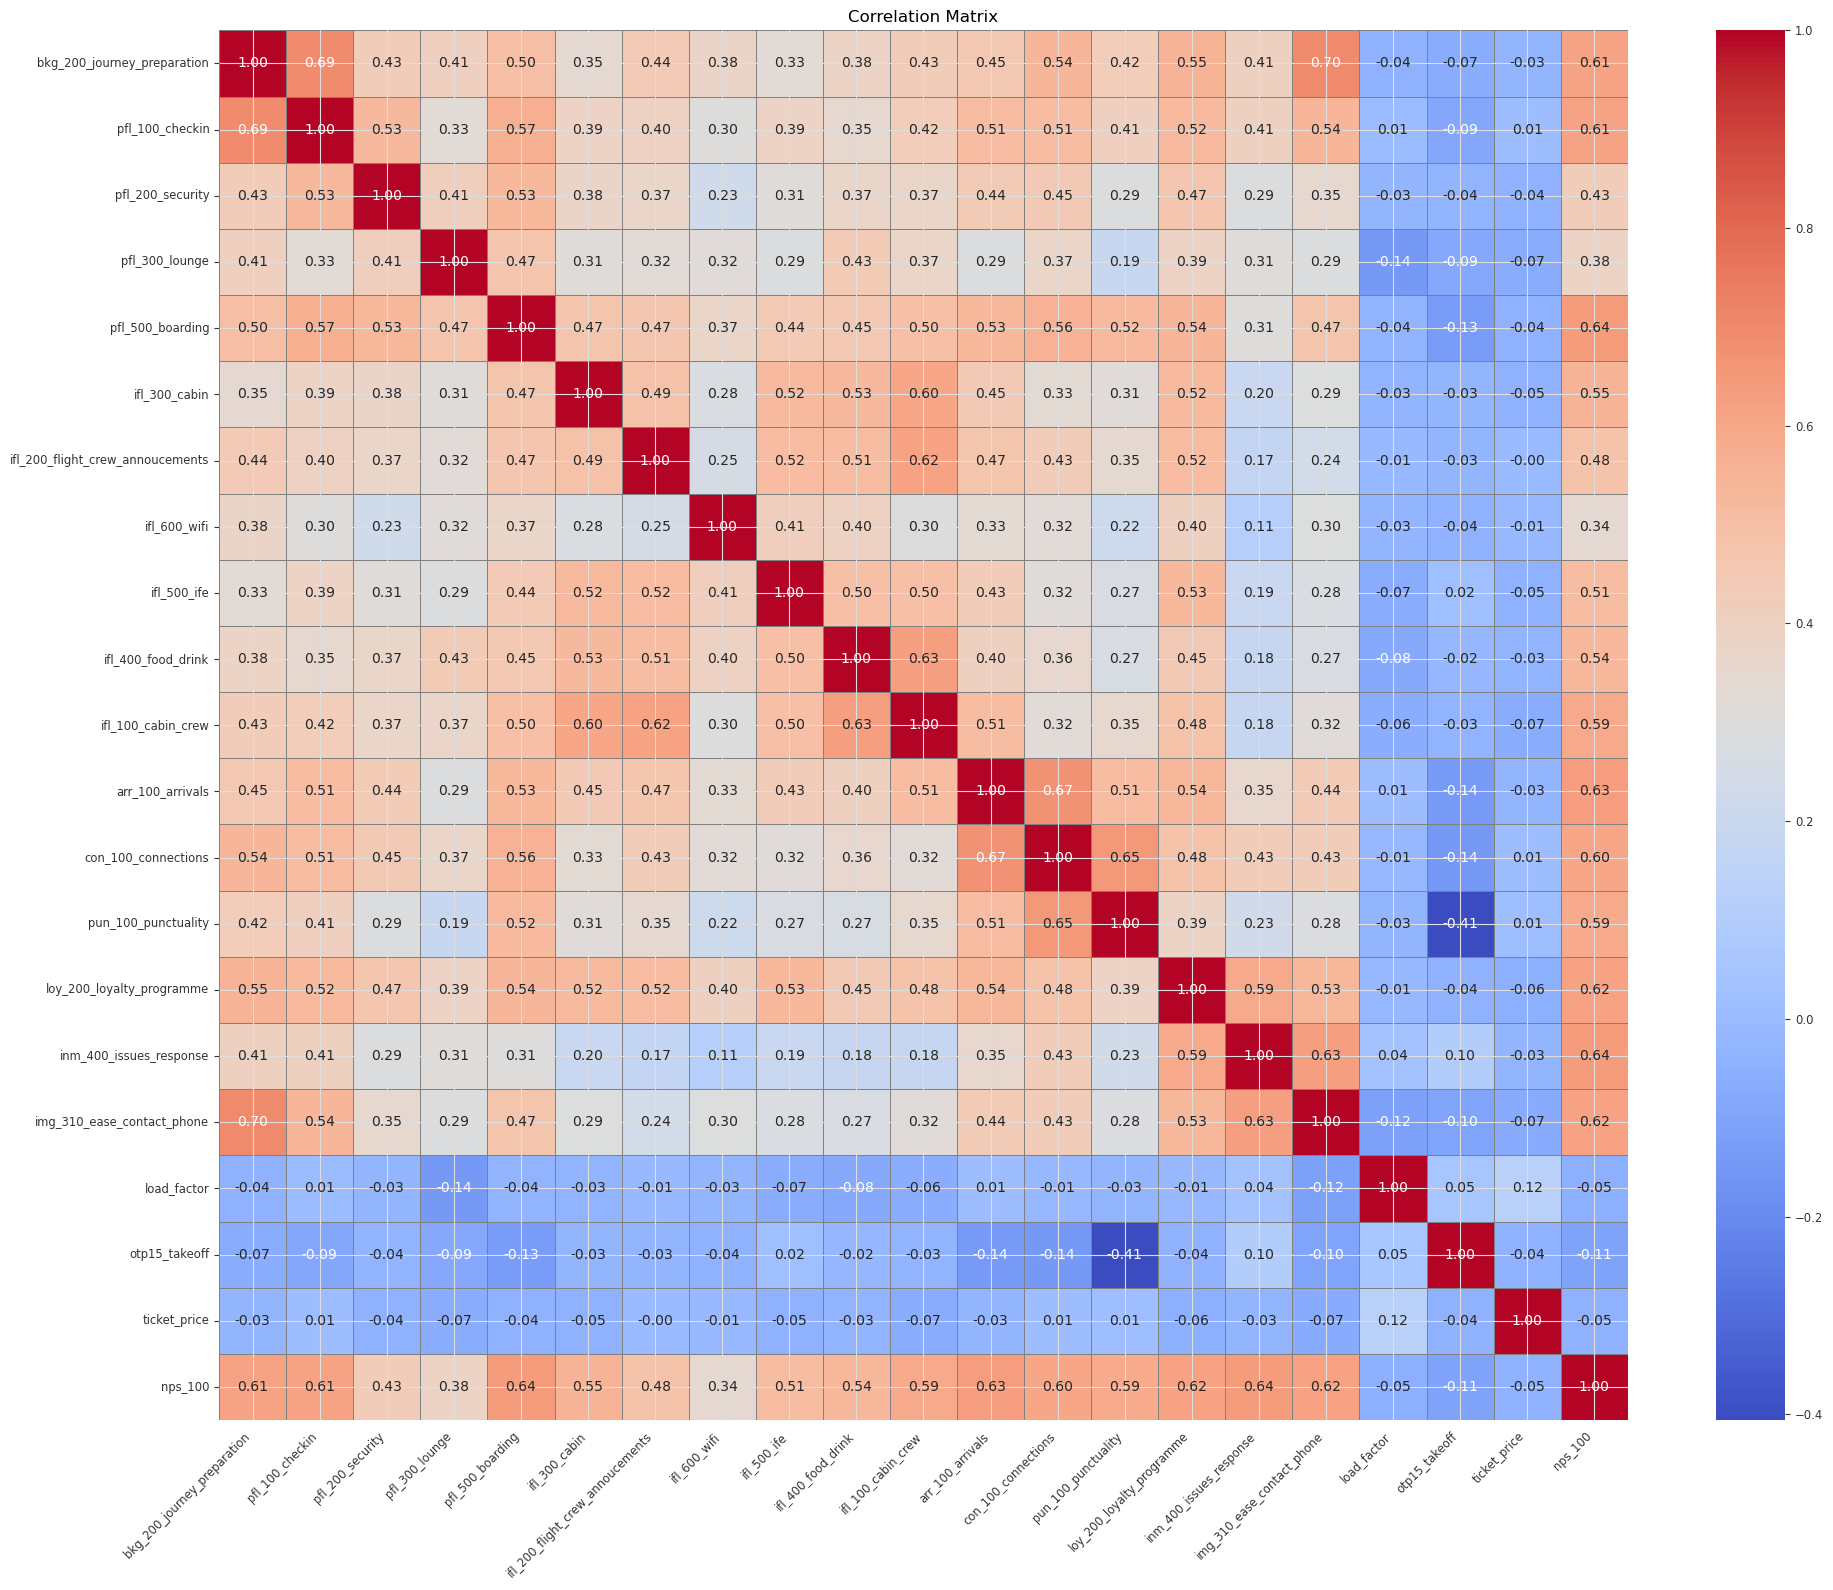

In [44]:
corr_matrix = df_historic[(df_historic['cabin_in_surveyed_flight'] == 'Business') & (df_historic['haul'] == 'LH') & (df_historic['date_flight_local'] >= pd.to_datetime('2023-03-01')) & (df_historic['date_flight_local'] <= pd.to_datetime('2023-03-31'))][cols].corr()
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(20, 16))  # You can adjust the size to fit your specific requirements
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='gray')

# Title and labels (optional)
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Ensure y labels are horizontal for readability

# Show the plot
plt.tight_layout()  # Adjusts plot borders and prevents cutoff of labels
plt.show()

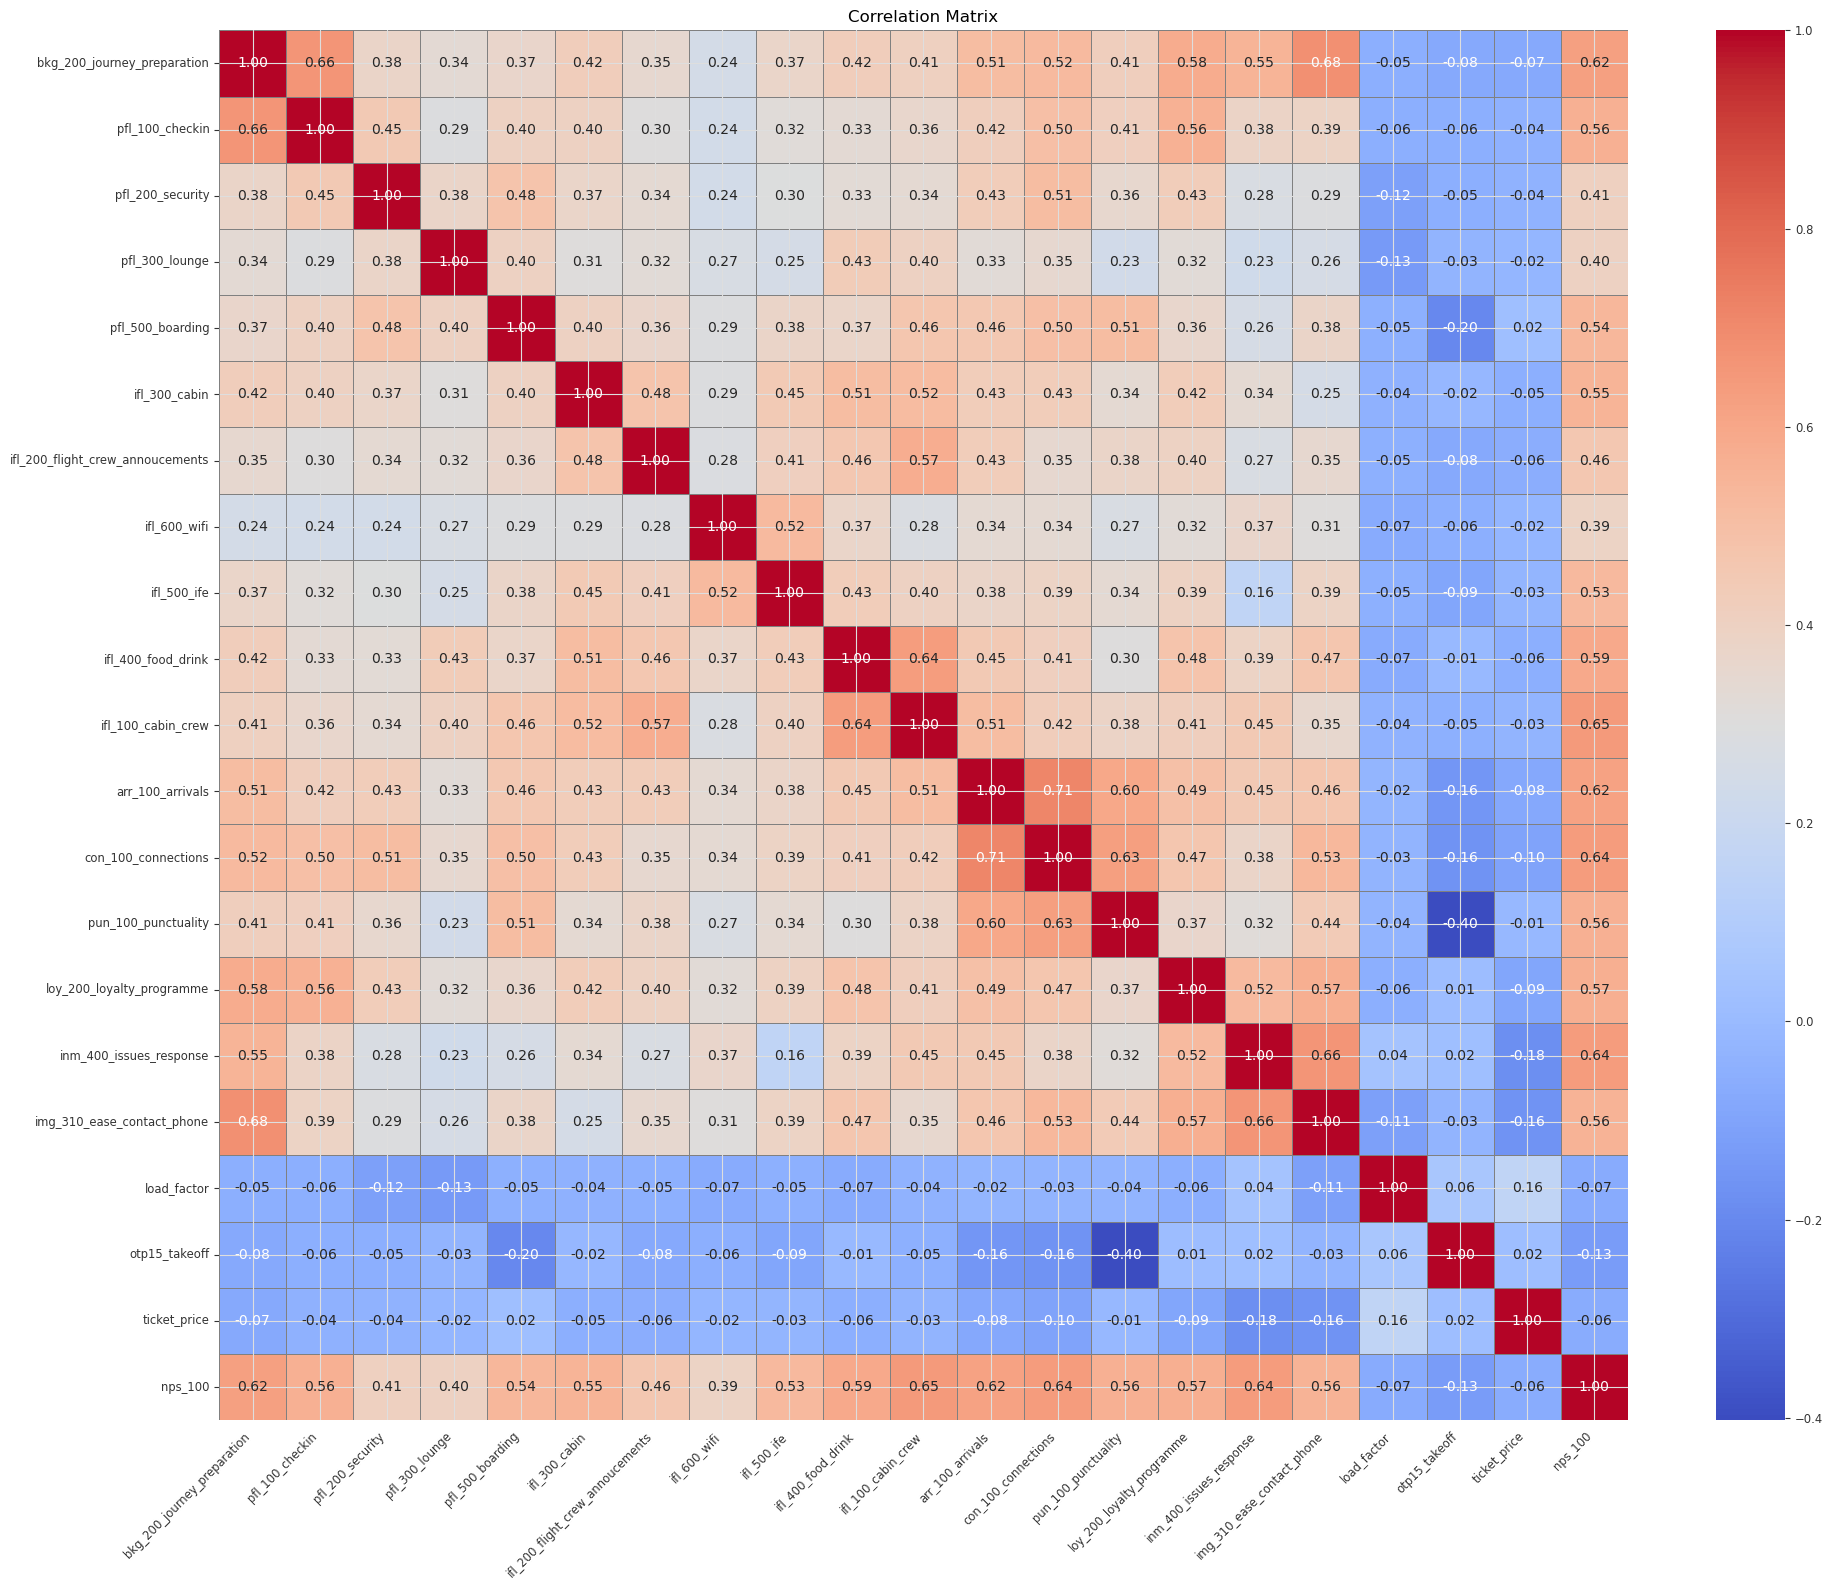

In [41]:
corr_matrix = df_for_correlation[cols].corr()
# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(20, 16))  # You can adjust the size to fit your specific requirements
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True, linewidths=0.5, linecolor='gray')

# Title and labels (optional)
plt.title('Correlation Matrix')
plt.xticks(rotation=45, ha='right')  # Rotate x labels for better readability
plt.yticks(rotation=0)  # Ensure y labels are horizontal for readability

# Show the plot
plt.tight_layout()  # Adjusts plot borders and prevents cutoff of labels
plt.show()

## Agregation logic

Given a date it takes it as an "end_date" and computes every interval with previous dates. Then it perfomr the satisfaction, NPS, load factor and otp aggregations for that particular interval.

In [27]:
# Funciones auxiliares
def calculate_nps(promoters, detractors, total_responses):
    """Calcula el Net Promoter Score (NPS)."""
    return ((promoters - detractors) / total_responses) * 100 if total_responses != 0 else 0

def calculate_weighted_nps(group_df):
    """Calcula el NPS ponderado para un grupo de datos."""
    promoters_weight = group_df.loc[group_df['nps_100'] > 8, 'monthly_weight'].sum()
    detractors_weight = group_df.loc[group_df['nps_100'] <= 6, 'monthly_weight'].sum()
    total_weight = group_df['monthly_weight'].sum()
    
    if total_weight > 0:
        return (promoters_weight - detractors_weight) / total_weight * 100
    else:
        return 0

def calculate_satisfaction(df, variable):
    """Calcula la tasa de satisfacción para una variable dada, utilizando pesos mensuales si están disponibles."""
    # Comprobar si la columna 'monthly_weight' existe y no está completamente vacía para los datos relevantes
    if 'monthly_weight' in df.columns and not df[df[variable].notnull()]['monthly_weight'].isnull().all():
        # Suma de los pesos donde la variable es >= 8 y satisface la condición de estar satisfecho
        satisfied_weight = df[df[variable] >= 8]['monthly_weight'].sum()
        # Suma de todos los pesos donde la variable no es NaN
        total_weight = df[df[variable].notnull()]['monthly_weight'].sum()
        # Calcula el porcentaje de satisfacción usando los pesos
        return (satisfied_weight / total_weight) * 100 if total_weight != 0 else 0
    else:
        # Contar respuestas satisfechas
        satisfied_count = df[df[variable] >= 8].shape[0]
        # Contar total de respuestas válidas
        total_count = df[variable].notnull().sum()
        # Calcula el porcentaje de satisfacción usando conteo
        return (satisfied_count / total_count) * 100 if total_count != 0 else 0


def calculate_otp(df, variable='otp15_takeoff'):
    """Calcula el On-Time Performance (OTP) como el porcentaje de valores igual a 1."""
    on_time_count = (df[variable] == 0).sum()
    total_count = df[variable].notnull().sum()
    return (on_time_count / total_count) * 100 if total_count > 0 else 0


def calculate_load_factor(df, pax_column, capacity_column):
    """Calcula el factor de carga para una cabina específica."""
    total_pax = df[pax_column].sum()
    total_capacity = df[capacity_column].sum()
    # Evitar la división por cero
    if total_capacity > 0:
        return (total_pax / total_capacity) * 100
    else:
        return 0

    
def calculate_metrics_summary(df, start_date, end_date, touchpoints):
    # Filtrar por rango de fechas
    df_filtered = df[(df['date_flight_local'] >= pd.to_datetime(start_date)) & (df['date_flight_local'] <= pd.to_datetime(end_date))]
    
    # Mapeo de cabinas a columnas de pax y capacidad
    cabin_mapping = {
        'Economy': ('pax_economy', 'capacity_economy'),
        'Business': ('pax_business', 'capacity_business'),
        'Premium Economy': ('pax_premium_ec', 'capacity_premium_ec')
    }
    
    results_list = []
    
    for (cabin, haul), group_df in df_filtered.groupby(['cabin_in_surveyed_flight', 'haul']):
        
        print(f'CABIN/HAUL: {cabin}/{haul}')
        result = {
            'start_date': start_date,
            'end_date': end_date,
            'cabin_in_surveyed_flight': cabin,
            'haul': haul,
            'otp15_takeoff': calculate_otp(group_df)
        }
        
        # Calcula el NPS para el grupo
        promoters = (group_df['nps_100'] >= 9).sum()
        detractors = (group_df['nps_100'] <= 6).sum()
        total_responses = group_df['nps_100'].notnull().sum()
        result['NPS'] = calculate_nps(promoters, detractors, total_responses) if total_responses else None
        
        # Calcula el NPS ponderado para el grupo
        result['NPS_weighted'] = calculate_weighted_nps(group_df)
        
        # Satisfacción para cada touchpoint
        for tp in touchpoints:
            result[f'{tp}_satisfaction'] = calculate_satisfaction(group_df, tp)
            
        
        # Calcula el factor de carga para la cabina
        pax_column, capacity_column = cabin_mapping.get(cabin, (None, None))
        if pax_column and capacity_column:
            result['load_factor'] = calculate_load_factor(group_df, pax_column, capacity_column)
        
        results_list.append(result)
    
    return pd.DataFrame(results_list)

def generate_date_intervals(start_date, end_date):
    """Genera una lista de tuplas con intervalos de fechas desde start_date hasta end_date."""
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    intervals = [(start_date + pd.Timedelta(days=d), end_date) for d in range((end_date - start_date).days + 1)]
    return intervals

def calculate_metrics_for_intervals(df, touchpoints, start_date, end_date):
    """Calcula las métricas para todos los intervalos posibles hasta end_date."""
    intervals = generate_date_intervals(start_date, end_date)
    all_metrics = []

    for interval_start, interval_end in intervals:
        interval_metrics = calculate_metrics_summary(df, interval_start, interval_end, touchpoints)
        print(f"Interval: {interval_start} to {interval_end}, Data points: {len(interval_metrics)}")
        all_metrics.append(interval_metrics)

    
    # Concatenar todos los DataFrames de resultados en uno solo
    results_df = pd.concat(all_metrics, ignore_index=True)
    return results_df

# # Ejemplo de uso:
# # touchpoints = ['tp1', 'tp2', 'tp3']  # Asegúrate de reemplazar estos con los nombres reales de tus touchpoints
# df_result = calculate_metrics_summary(df_historic, '2023-01-01', '2023-01-31', touchpoints)
# # print(df_result)

# # Definir la fecha de inicio del año y la fecha de fin específica
# start_date = '2023-03-01'
# end_date = '2023-05-01'



# results_intervals_df = calculate_metrics_for_intervals(df_historic, touchpoints, start_date, end_date)




In [ ]:
results_intervals_df

In [ ]:
import pandas as pd
from datetime import datetime, timedelta

# Assume df_historic and touchpoints are defined elsewhere

# Convert start_date and end_date strings to datetime objects for manipulation
start_date = datetime.strptime('2024-01-01', '%Y-%m-%d')
original_end_date = datetime.strptime('2024-04-08', '%Y-%m-%d')

# Initialize an empty DataFrame to store the results from each interval
all_intervals_results = pd.DataFrame()

# Loop over the range from (original_end_date - 15 days) to original_end_date
for offset in range(0, 16):  # Including the 15th day
    # Calculate the new end_date for this iteration
    end_date = original_end_date - timedelta(days=offset)
    
    # Convert end_date back to string format if your function expects a string
    end_date_str = end_date.strftime('%Y-%m-%d')
    
    # Call your function with the current interval's end_date
    interval_results = calculate_metrics_for_intervals(df_historic, touchpoints, start_date.strftime('%Y-%m-%d'), end_date_str)
    
    # Assuming interval_results is a DataFrame, you may want to add a column to indicate the end_date for this interval's results
    interval_results['interval_end_date'] = end_date_str
    
    # Append the results for this interval to the all_intervals_results DataFrame
    all_intervals_results = pd.concat([all_intervals_results, interval_results])

# Reset the index of the final DataFrame if necessary
all_intervals_results.reset_index(drop=True, inplace=True)

# Now, all_intervals_results contains the metrics calculated for each interval


In [ ]:
all_intervals_results

In [ ]:
all_intervals_results.to_csv('intervals.csv')

# 2. Prediction with Darts model

In [28]:
march_2023 = calculate_metrics_summary(df_historic, '2023-03-01', '2023-03-31', touchpoints)
march_2024 = calculate_metrics_summary(df_historic, '2024-03-01', '2024-03-31', touchpoints)

CABIN/HAUL: Business/LH
CABIN/HAUL: Business/SH
CABIN/HAUL: Economy/LH
CABIN/HAUL: Economy/SH
CABIN/HAUL: Premium Economy/LH
CABIN/HAUL: Business/LH
CABIN/HAUL: Business/SH
CABIN/HAUL: Economy/LH
CABIN/HAUL: Economy/SH
CABIN/HAUL: Premium Economy/LH


In [30]:
march_2024[(march_2024['cabin_in_surveyed_flight'] == 'Business') & (march_2024['haul'] == 'LH')]

,start_date,end_date,cabin_in_surveyed_flight,haul,otp15_takeoff,NPS,NPS_weighted,bkg_200_journey_preparation_satisfaction,pfl_100_checkin_satisfaction,pfl_200_security_satisfaction,pfl_300_lounge_satisfaction,pfl_500_boarding_satisfaction,ifl_300_cabin_satisfaction,ifl_200_flight_crew_annoucements_satisfaction,ifl_600_wifi_satisfaction,ifl_500_ife_satisfaction,ifl_400_food_drink_satisfaction,ifl_100_cabin_crew_satisfaction,arr_100_arrivals_satisfaction,con_100_connections_satisfaction,pun_100_punctuality_satisfaction,loy_200_loyalty_programme_satisfaction,inm_400_issues_response_satisfaction,img_310_ease_contact_phone_satisfaction,load_factor
0,2024-03-01,2024-03-31,Business,LH,79.643,36.097,36.097,73.236,83.351,84.297,76.781,77.409,77.601,81.453,49.158,70.891,69.362,81.084,80.298,71.599,81.007,74.667,14.201,64.706,91.969


In [97]:
calculate_metrics_summary(df_historic, '2024-03-01', '2024-03-31', touchpoints)

CABIN/HAUL: Business/LH
bkg_200_journey_preparation
Satisfied_count:602
Total_count:822
pfl_100_checkin
Satisfied_count:771
Total_count:925
pfl_200_security
Satisfied_count:773
Total_count:917
pfl_300_lounge
Satisfied_count:625
Total_count:814
pfl_500_boarding
Satisfied_count:723
Total_count:934
ifl_300_cabin
Satisfied_count:731
Total_count:942
ifl_200_flight_crew_annoucements
Satisfied_count:751
Total_count:922
ifl_600_wifi
Satisfied_count:292
Total_count:594
ifl_500_ife
Satisfied_count:565
Total_count:797
ifl_400_food_drink
Satisfied_count:652
Total_count:940
ifl_100_cabin_crew
Satisfied_count:763
Total_count:941
arr_100_arrivals
Satisfied_count:754
Total_count:939
con_100_connections
Satisfied_count:300
Total_count:419
pun_100_punctuality
Satisfied_count:772
Total_count:953
loy_200_loyalty_programme
Satisfied_count:448
Total_count:600
inm_400_issues_response
Satisfied_count:24
Total_count:169
img_310_ease_contact_phone
Satisfied_count:143
Total_count:221
CABIN/HAUL: Business/SH
bkg_

,start_date,end_date,cabin_in_surveyed_flight,haul,otp15_takeoff,NPS,NPS_weighted,bkg_200_journey_preparation_satisfaction,pfl_100_checkin_satisfaction,pfl_200_security_satisfaction,pfl_300_lounge_satisfaction,pfl_500_boarding_satisfaction,ifl_300_cabin_satisfaction,ifl_200_flight_crew_annoucements_satisfaction,ifl_600_wifi_satisfaction,ifl_500_ife_satisfaction,ifl_400_food_drink_satisfaction,ifl_100_cabin_crew_satisfaction,arr_100_arrivals_satisfaction,con_100_connections_satisfaction,pun_100_punctuality_satisfaction,loy_200_loyalty_programme_satisfaction,inm_400_issues_response_satisfaction,img_310_ease_contact_phone_satisfaction,load_factor
0,2024-03-01,2024-03-31,Business,LH,79.643,36.097,36.097,73.236,83.351,84.297,76.781,77.409,77.601,81.453,49.158,70.891,69.362,81.084,80.298,71.599,81.007,74.667,14.201,64.706,91.969
1,2024-03-01,2024-03-31,Business,SH,88.239,51.105,51.105,75.726,84.270,80.846,73.570,79.321,76.145,80.778,53.303,44.860,76.444,88.808,82.922,74.068,82.395,72.346,16.049,56.158,82.588
2,2024-03-01,2024-03-31,Economy,LH,77.701,25.922,25.890,68.074,76.162,83.033,68.687,76.253,68.697,80.929,46.111,75.944,59.014,76.478,77.640,68.557,77.636,66.183,12.702,56.633,91.182
3,2024-03-01,2024-03-31,Economy,SH,87.519,38.980,39.021,72.109,79.247,80.429,74.328,76.355,73.541,79.016,44.723,43.453,55.363,82.051,78.652,69.251,77.714,66.286,11.845,54.107,88.102
4,2024-03-01,2024-03-31,Premium Economy,LH,80.034,24.061,24.061,66.730,79.685,81.898,88.732,78.383,67.753,78.070,40.952,74.438,53.713,71.575,77.257,67.293,79.863,72.492,18.750,49.635,89.701


In [100]:
april_2023 = calculate_metrics_summary(df_historic, '2023-04-01', '2023-04-30', touchpoints)
april_2024 = calculate_metrics_summary(df_historic, '2024-04-01', '2024-04-30', touchpoints)

CABIN/HAUL: Business/LH
CABIN/HAUL: Business/SH
CABIN/HAUL: Economy/LH
CABIN/HAUL: Economy/SH
CABIN/HAUL: Premium Economy/LH
CABIN/HAUL: Business/LH
CABIN/HAUL: Business/SH
CABIN/HAUL: Economy/LH
CABIN/HAUL: Economy/SH
CABIN/HAUL: Premium Economy/LH


In [33]:
april_2023

,start_date,end_date,cabin_in_surveyed_flight,haul,otp15_takeoff,NPS,NPS_weighted,bkg_200_journey_preparation_satisfaction,pfl_100_checkin_satisfaction,pfl_200_security_satisfaction,pfl_300_lounge_satisfaction,pfl_500_boarding_satisfaction,ifl_300_cabin_satisfaction,ifl_200_flight_crew_annoucements_satisfaction,ifl_600_wifi_satisfaction,ifl_500_ife_satisfaction,ifl_400_food_drink_satisfaction,ifl_100_cabin_crew_satisfaction,arr_100_arrivals_satisfaction,con_100_connections_satisfaction,pun_100_punctuality_satisfaction,loy_200_loyalty_programme_satisfaction,inm_400_issues_response_satisfaction,img_310_ease_contact_phone_satisfaction,load_factor
0,2023-04-01,2023-04-30,Business,LH,86.171,45.486,45.486,73.635,81.451,84.217,77.438,80.165,81.069,85.866,43.720,75.210,68.415,84.400,82.305,72.603,87.429,75.568,19.492,55.502,92.546
1,2023-04-01,2023-04-30,Business,SH,88.725,45.836,45.796,72.776,79.407,79.877,72.922,76.848,76.119,78.366,43.875,48.214,72.414,84.951,79.670,74.504,80.029,66.667,16.471,53.500,83.391
2,2023-04-01,2023-04-30,Economy,LH,86.056,23.057,23.066,66.537,73.341,83.245,76.296,75.354,66.351,79.235,45.109,77.188,55.848,74.120,78.127,71.202,80.818,64.089,12.723,48.690,89.948
3,2023-04-01,2023-04-30,Economy,SH,89.184,37.064,37.052,69.723,76.557,80.340,77.935,75.304,72.455,77.544,40.891,48.162,50.639,79.957,77.663,69.988,77.906,66.950,15.893,51.857,87.582
4,2023-04-01,2023-04-30,Premium Economy,LH,88.383,27.563,27.563,67.179,74.353,83.726,82.000,78.037,70.602,79.669,49.697,74.185,52.681,73.903,79.767,71.000,82.916,68.500,0.000,40.000,88.786


In [101]:
march_and_april_2023 = calculate_metrics_summary(df_historic, '2023-03-01', '2023-04-30', touchpoints)
march_and_april_2024 = calculate_metrics_summary(df_historic, '2024-03-01', '2024-04-30', touchpoints)

CABIN/HAUL: Business/LH
CABIN/HAUL: Business/SH
CABIN/HAUL: Economy/LH
CABIN/HAUL: Economy/SH
CABIN/HAUL: Premium Economy/LH
CABIN/HAUL: Business/LH
CABIN/HAUL: Business/SH
CABIN/HAUL: Economy/LH
CABIN/HAUL: Economy/SH
CABIN/HAUL: Premium Economy/LH


In [35]:
march_and_april_2023

,start_date,end_date,cabin_in_surveyed_flight,haul,otp15_takeoff,NPS,NPS_weighted,bkg_200_journey_preparation_satisfaction,pfl_100_checkin_satisfaction,pfl_200_security_satisfaction,pfl_300_lounge_satisfaction,pfl_500_boarding_satisfaction,ifl_300_cabin_satisfaction,ifl_200_flight_crew_annoucements_satisfaction,ifl_600_wifi_satisfaction,ifl_500_ife_satisfaction,ifl_400_food_drink_satisfaction,ifl_100_cabin_crew_satisfaction,arr_100_arrivals_satisfaction,con_100_connections_satisfaction,pun_100_punctuality_satisfaction,loy_200_loyalty_programme_satisfaction,inm_400_issues_response_satisfaction,img_310_ease_contact_phone_satisfaction,load_factor
0,2023-03-01,2023-04-30,Business,LH,82.745,41.922,41.927,72.938,78.695,82.126,74.890,78.129,79.331,82.893,43.552,74.399,67.080,83.363,80.059,70.294,83.266,73.623,13.971,54.186,92.894
1,2023-03-01,2023-04-30,Business,SH,85.505,40.941,40.747,70.217,76.541,77.836,70.617,74.525,75.068,77.273,43.893,48.333,71.923,84.080,76.775,71.406,75.482,66.485,15.223,51.538,84.199
2,2023-03-01,2023-04-30,Economy,LH,82.656,18.060,17.749,64.676,71.294,81.397,75.934,72.332,65.111,77.932,43.695,75.407,53.958,71.978,75.796,68.067,77.223,62.836,11.263,47.494,89.981
3,2023-03-01,2023-04-30,Economy,SH,86.103,28.374,28.091,65.940,73.226,77.767,75.673,71.320,69.342,75.109,40.036,48.757,47.291,76.599,73.483,65.403,72.883,64.100,14.105,47.392,88.297
4,2023-03-01,2023-04-30,Premium Economy,LH,84.927,26.997,26.965,66.076,73.642,82.176,72.269,75.660,70.468,78.140,49.570,72.914,51.950,72.551,77.931,68.810,81.215,69.365,2.312,41.393,88.491


In [102]:
# Concatenate the DataFrames
concatenated_df = pd.concat([march_2023, april_2023, march_and_april_2023,march_2024, april_2024, march_and_april_2024], ignore_index=True)

# Display the concatenated DataFrame
print(concatenated_df)

    start_date    end_date cabin_in_surveyed_flight haul  otp15_takeoff  \
0   2023-03-01  2023-03-31                 Business   LH         79.092   
1   2023-03-01  2023-03-31                 Business   SH         81.973   
2   2023-03-01  2023-03-31                  Economy   LH         78.152   
3   2023-03-01  2023-03-31                  Economy   SH         82.708   
4   2023-03-01  2023-03-31          Premium Economy   LH         81.556   
5   2023-04-01  2023-04-30                 Business   LH         85.882   
6   2023-04-01  2023-04-30                 Business   SH         88.725   
7   2023-04-01  2023-04-30                  Economy   LH         85.714   
8   2023-04-01  2023-04-30                  Economy   SH         89.184   
9   2023-04-01  2023-04-30          Premium Economy   LH         88.383   
10  2023-03-01  2023-04-30                 Business   LH         82.513   
11  2023-03-01  2023-04-30                 Business   SH         85.505   
12  2023-03-01  2023-04-3

In [ ]:
import pkg_resources

# List of libraries you want to check versions for
libraries = [
    "s3fs", "boto", "boto3", "botocore", "numpy", "scikit-image",
    "scikit-learn", "scipy", "PyYAML", "pandas", "darts",
    "optuna", "shap", "lightgbm"
]

# Check the installed version for each library and print it
for library in libraries:
    try:
        version = pkg_resources.get_distribution(library).version
        print(f"{library}: {version}")
    except pkg_resources.DistributionNotFound:
        print(f"{library} is not installed.")


In [27]:
import darts
from darts import TimeSeries
from darts.utils.timeseries_generation import (
    gaussian_timeseries,
    linear_timeseries,
    sine_timeseries,
)

from darts.metrics import mape, smape, mae
from darts.dataprocessing.transformers import Scaler
from darts.utils.timeseries_generation import datetime_attribute_timeseries

from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import RandomForestRegressor

import lightgbm

from darts.models import LightGBMModel

from darts.models import LightGBMModel, RandomForest, LinearRegressionModel
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis

from darts.explainability.shap_explainer import ShapExplainer
import pickle
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from darts.models import LinearRegressionModel, LightGBMModel, RandomForest
from calendar import month_name as mn
import os

import shap
import pandas as pd

In [ ]:
targets_df = pd.read_csv('targets.csv')

In [ ]:
targets_df

In [ ]:
day_predict_df = pd.read_csv('intervals.csv')

In [ ]:
targets_df

In [ ]:
targets_df=targets_df[targets_df['cabin']!='Global']

targets_df['insert_date_ci']='2023-11-21'

targets_df.rename(columns={
    'cabin' : 'cabin_in_surveyed_flight',
    'date_flight_local': 'end_date'  # Assuming you want to consider end_date as the equivalent of date_flight_local
}, inplace=True)
day_predict_df.rename(columns={
    'interval_end_date': 'insert_date_ci'  # Assuming you want to consider end_date as the equivalent of date_flight_local
}, inplace=True)

# Correct the conversion to datetime objects
targets_df['end_date'] = pd.to_datetime(targets_df['end_date'])

# Compute 'start_date' as the first day of the corresponding month
# Using dt.to_period('M').to_timestamp() to safely navigate datetime formats
targets_df['start_date'] = targets_df['end_date'].dt.to_period('M').dt.to_timestamp()

day_predict_df.drop(columns=['Unnamed: 0', 'NPS'], inplace=True)

concatenated_df = pd.concat([day_predict_df,targets_df], ignore_index=True)

# Ensure 'start_date' and 'end_date' are datetime objects
concatenated_df['start_date'] = pd.to_datetime(concatenated_df['start_date']).dt.date
concatenated_df['end_date'] = pd.to_datetime(concatenated_df['end_date']).dt.date



In [103]:
concatenated_df['insert_date_ci']='2024-05-06'

In [29]:
concatenated_df

,start_date,end_date,cabin_in_surveyed_flight,haul,otp15_takeoff,NPS,NPS_weighted,bkg_200_journey_preparation_satisfaction,pfl_100_checkin_satisfaction,pfl_200_security_satisfaction,pfl_300_lounge_satisfaction,pfl_500_boarding_satisfaction,ifl_300_cabin_satisfaction,ifl_200_flight_crew_annoucements_satisfaction,ifl_600_wifi_satisfaction,ifl_500_ife_satisfaction,ifl_400_food_drink_satisfaction,ifl_100_cabin_crew_satisfaction,arr_100_arrivals_satisfaction,con_100_connections_satisfaction,pun_100_punctuality_satisfaction,loy_200_loyalty_programme_satisfaction,inm_400_issues_response_satisfaction,img_310_ease_contact_phone_satisfaction,load_factor,insert_date_ci
0,2023-03-01,2023-03-31,Business,LH,79.225,38.263,38.263,72.207,75.904,80.024,72.296,76.053,77.553,79.804,43.404,73.571,65.707,82.297,77.765,68.269,78.991,71.598,9.740,52.941,93.240,2024-05-06
1,2023-03-01,2023-03-31,Business,SH,81.973,35.570,35.570,67.335,73.350,75.591,68.176,71.953,73.913,76.081,43.909,48.438,71.380,83.128,73.602,68.123,70.493,66.296,14.218,49.474,85.081,2024-05-06
2,2023-03-01,2023-03-31,Economy,LH,78.531,11.998,11.998,62.401,68.808,79.137,75.472,68.656,63.599,76.343,42.038,73.220,51.660,69.368,72.957,64.579,72.863,61.367,9.902,46.154,90.021,2024-05-06
3,2023-03-01,2023-03-31,Economy,SH,82.711,18.808,18.818,61.852,69.542,74.916,73.477,66.930,65.912,72.428,39.157,49.333,43.754,72.897,68.873,60.820,67.354,61.196,12.729,43.375,89.060,2024-05-06
4,2023-03-01,2023-03-31,Premium Economy,LH,81.556,26.444,26.444,65.000,72.955,80.682,65.217,73.363,70.337,76.659,49.457,71.625,51.242,71.236,76.136,66.818,79.556,70.039,4.396,42.857,88.206,2024-05-06
5,2023-04-01,2023-04-30,Business,LH,86.171,45.486,45.486,73.635,81.451,84.217,77.438,80.165,81.069,85.866,43.720,75.210,68.415,84.400,82.305,72.603,87.429,75.568,19.492,55.502,92.546,2024-05-06
6,2023-04-01,2023-04-30,Business,SH,88.725,45.836,45.796,72.776,79.407,79.877,72.922,76.848,76.119,78.366,43.875,48.214,72.414,84.951,79.670,74.504,80.029,66.667,16.471,53.500,83.391,2024-05-06
7,2023-04-01,2023-04-30,Economy,LH,86.056,23.057,23.066,66.537,73.341,83.245,76.296,75.354,66.351,79.235,45.109,77.188,55.848,74.120,78.127,71.202,80.818,64.089,12.723,48.690,89.948,2024-05-06
8,2023-04-01,2023-04-30,Economy,SH,89.184,37.064,37.052,69.723,76.557,80.340,77.935,75.304,72.455,77.544,40.891,48.162,50.639,79.957,77.663,69.988,77.906,66.950,15.893,51.857,87.582,2024-05-06
9,2023-04-01,2023-04-30,Premium Economy,LH,88.383,27.563,27.563,67.179,74.353,83.726,82.000,78.037,70.602,79.669,49.697,74.185,52.681,73.903,79.767,71.000,82.916,68.500,0.000,40.000,88.786,2024-05-06


In [104]:
def process_dataframe(df):
    df.drop(columns=['pun_100_punctuality_satisfaction', 'inm_400_issues_response_satisfaction'], inplace=True)
    # Agrupar y procesar los datos
    grouped_dfs = {}
    features = {}
    for group_name, group_data in df.groupby(['cabin_in_surveyed_flight', 'haul']):
        cabin_value, haul_value = group_name
        group_df = group_data.copy()
        group_df_name = f'{cabin_value}_{haul_value}_df'
        
        # Identificar las columnas de características
        satisfaction_cols = [col for col in df.columns if col.endswith('_satisfaction')]
        otp_cols = ['otp15_takeoff']
        features_cols = satisfaction_cols + ['load_factor'] + otp_cols
        cols_to_keep = ['insert_date_ci', 'start_date','end_date','cabin_in_surveyed_flight', 'haul'] + features_cols + ['NPS_weighted']

        # Filtrar las columnas en el grupo y actualizar el diccionario de características
        grouped_df = group_df[cols_to_keep]
        features[group_df_name] = features_cols
        grouped_dfs[group_df_name] = grouped_df

    # Reconstruir el DataFrame original
    df = pd.concat(grouped_dfs.values())
    df.reset_index(drop=True, inplace=True)

    return df, grouped_dfs, features

# Aplicar la función a cada DataFrame y almacenar los resultados en las variables correspondientes
day_predict_df, day_predict_df_grouped_dfs, features_cols = process_dataframe(concatenated_df)

In [ ]:
day_predict_df_grouped_dfs.keys()

In [49]:
os.getcwd()

'/root/NPS forecasting model/nps_aggregated_model/Pipeline target_explainability_model/nps_aggregated_explainability/develop'

In [105]:
satisfaction_cols = [col for col in day_predict_df.columns if col.endswith('_satisfaction')]
otp_cols = ['otp15_takeoff']
features_cols = satisfaction_cols + ['load_factor'] + otp_cols

In [106]:
import pandas as pd
import numpy as np
import pickle
import os
import pandas as pd
from darts.timeseries import TimeSeries
import os
import pickle


def compute_shap_and_prediction(row, key, features_cols):
    """
    Computes SHAP values and the predicted NPS for a given row.
    
    Parameters:
    - row_df: The DataFrame row for which to compute SHAP values and prediction.
    - key: The key identifying the specific model and scaler to use.
    - features_cols: List of column names representing features used by the model.
    
    Returns:
    - A tuple containing SHAP values as a dictionary and the predicted NPS.
    """
    # Logic to prepare the row for SHAP value computation and prediction
    aux_nps_ts = TimeSeries.from_series(pd.Series([0]))
    aux_row = pd.DataFrame(0, index=[0], columns=row.columns)
    row_df = pd.concat([aux_row, row]).reset_index(drop=True)
    
    # Load the pre-trained model and scaler
    best_tuned_model_dataframe_path = os.path.join('targets_model', f"best_tuned_dataframe_{key}.pkl")
    with open(best_tuned_model_dataframe_path, 'rb') as dataframe_file:
        best_tuned_model = pickle.load(dataframe_file)
    
    future_scaler_path = os.path.join('targets_model', f"future_scaler_{key}.pkl")
    with open(future_scaler_path, 'rb') as scaler_file:
        future_scaler = pickle.load(scaler_file)
    
    future_covariates_ts = TimeSeries.from_dataframe(row_df[features_cols])[-1:]
    future_covariates_ts_scaled = future_scaler.transform(future_covariates_ts)
    
    model_file_path = os.path.join('targets_model', f"best_tuned_mae_model_{key}_{best_tuned_model['model_name']}.pkl")
    with open(model_file_path, 'rb') as model_file:
        model = pickle.load(model_file)
    
    # Compute SHAP values and prediction
    shap_explain = ShapExplainer(model=model)
    shap_explained = shap_explain.explain(aux_nps_ts, foreground_future_covariates=future_covariates_ts_scaled)
    shap_explanation = shap_explained.get_shap_explanation_object(horizon=1)

    shap_values = shap_explanation[0].values
    base_value = shap_explanation[0].base_values
    pred_value = base_value + shap_values.sum()
    feature_names=[]
    for feat in shap_explanation.feature_names:
        name = [f for f in features_cols if f in feat]
        feature_names.append(name[0])
    
    
    # Convert SHAP values to a dictionary and adjust the logic based on your ShapExplainer
    shap_values_dict = {f"{feature}_nps": value for feature, value in zip(feature_names, shap_values)}
    shap_values_dict["out_prob_base"] = base_value,
    shap_values_dict["out_prob_nps"] = pred_value,
    
    return shap_values_dict, shap_explanation[0]


# Initialize a dictionary to store the augmented DataFrames
augmented_dfs = {}
explanations = {}

for key in day_predict_df_grouped_dfs.keys():
    # Initialize a list to collect augmented rows
    augmented_rows = []
    explanations[key]={}

    for index in range(len(day_predict_df_grouped_dfs[key])):
        # Access the row by its index using .iloc
        row_df = day_predict_df_grouped_dfs[key].iloc[[index]]

        # Compute SHAP values and predicted NPS here...
        # Assuming `compute_shap_and_prediction` is a function you'd implement
        # This function should return SHAP values as a dict and the predicted NPS
        shap_values, explanations[key][index] = compute_shap_and_prediction(row_df, key, features_cols)

        # For each feature, add its SHAP value to the row
        for feature_name, shap_value in shap_values.items():
            row_df[f'{feature_name}'] = shap_value

        # Add base value and predicted NPS columns
        # row_df['Base Value'] = shap_values['base_value']  # Adjust based on how you obtain the base value
        # row_df['Predicted NPS'] = predicted_nps
        print(key)
        print(index)
        print(row_df[['NPS_weighted', 'out_prob_nps']])

        # Append the augmented row to the list
        augmented_rows.append(row_df)
        

    # Concatenate all augmented rows to form the complete augmented DataFrame
    augmented_dfs[key] = pd.concat(augmented_rows).reset_index(drop=True)

# `augmented_dfs` now contains the augmented DataFrames with SHAP values and predictions
augmented_dfs

Business_LH_df
0
   NPS_weighted  out_prob_nps
0        38.829        37.032
Business_LH_df
1
   NPS_weighted  out_prob_nps
5        45.176        42.404
Business_LH_df
2
    NPS_weighted  out_prob_nps
10        42.031        38.250
Business_LH_df
3
    NPS_weighted  out_prob_nps
15        36.097        41.523
Business_LH_df
4
    NPS_weighted  out_prob_nps
20         0.000        42.123
Business_LH_df
5
    NPS_weighted  out_prob_nps
25        36.097        41.616
Business_SH_df
0
   NPS_weighted  out_prob_nps
1        35.570        27.847
Business_SH_df
1
   NPS_weighted  out_prob_nps
6        45.796        39.321
Business_SH_df
2
    NPS_weighted  out_prob_nps
11        40.747        35.284
Business_SH_df
3
    NPS_weighted  out_prob_nps
16        51.105        48.178
Business_SH_df
4
    NPS_weighted  out_prob_nps
21         0.000        47.511
Business_SH_df
5
    NPS_weighted  out_prob_nps
26        51.105        48.178
Economy_LH_df
0
   NPS_weighted  out_prob_nps
2        11.87

{'Business_LH_df':   insert_date_ci  start_date    end_date cabin_in_surveyed_flight haul  \
 0     2024-05-06  2023-03-01  2023-03-31                 Business   LH   
 1     2024-05-06  2023-04-01  2023-04-30                 Business   LH   
 2     2024-05-06  2023-03-01  2023-04-30                 Business   LH   
 3     2024-05-06  2024-03-01  2024-03-31                 Business   LH   
 4     2024-05-06  2024-04-01  2024-04-30                 Business   LH   
 5     2024-05-06  2024-03-01  2024-04-30                 Business   LH   
 
    bkg_200_journey_preparation_satisfaction  pfl_100_checkin_satisfaction  \
 0                                    72.301                        75.951   
 1                                    74.211                        81.418   
 2                                    73.274                        78.693   
 3                                    73.236                        83.351   
 4                                    74.807                     

In [107]:
march_2023_explanation=explanations['Business_LH_df'][0]

In [57]:
explanations['Business_LH_df'][0]

.values =
array([-1.20989694, -0.78142507, -0.12285824, -0.16259658, -0.81544521,
       -0.53955875, -0.01053333,  0.6614916 , -0.00378657, -2.50154167,
        0.42114629,  0.3255121 ,  0.42063157, -1.334065  , -0.65951994,
       -0.16031132, -0.0852103 ])

.base_values =
43.569127739701536

.data =
array([0.46460056, 0.50207229, 0.41755794, 0.50020154, 0.4951934 ,
       0.50906888, 0.5364235 , 0.49315012, 0.56146179, 0.46296334,
       0.54349966, 0.5023799 , 0.55669231, 0.47063511, 0.41541176,
       0.82562115, 0.34213615])

In [108]:
march_2024_explanation=explanations['Business_LH_df'][3]

In [109]:
def create_uplifting_explanation(explanation2, explanation1):
    """
    Create a new Explanation object representing the uplifting between two Explanation objects.

    Parameters:
        - explanation1: The first shap.Explanation object.
        - explanation2: The second shap.Explanation object.

    Returns:
        - A new shap.Explanation object representing the uplifting.
    """
    # Calculate the difference in values, base_values, and data
    diff_values = explanation2.values - explanation1.values
    
    diff_base_values = explanation1.base_values + sum(explanation1.values)
    diff_data = explanation2.data - explanation1.data

    # Create a new Explanation object with the difference values
    diff_explanation = shap.Explanation(values=diff_values, base_values=diff_base_values, data=diff_data,
                                        feature_names=explanation1.feature_names)

    return diff_explanation

In [110]:
march_diff_explanation = create_uplifting_explanation(march_2024_explanation, march_2023_explanation)

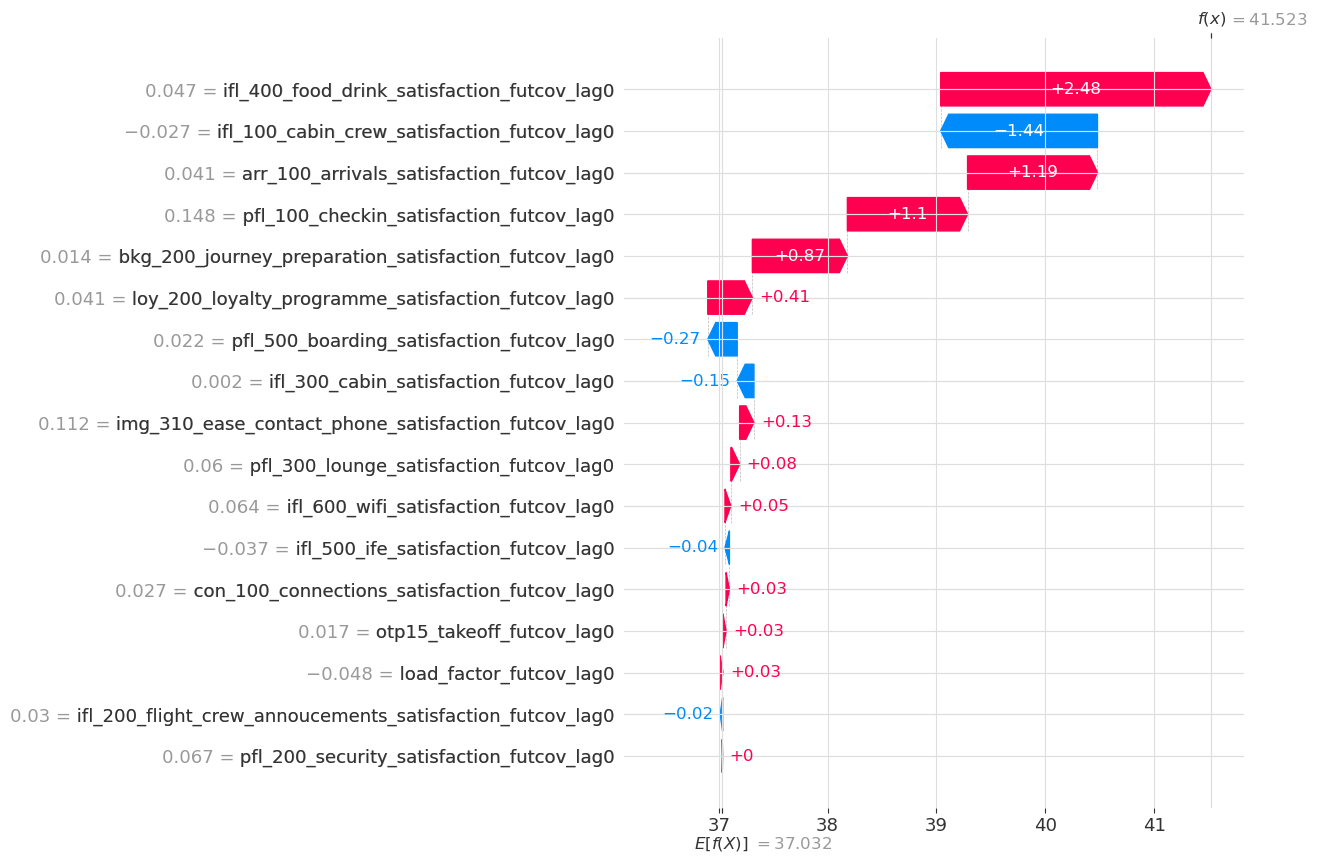

In [111]:
shap.plots.waterfall(march_diff_explanation, max_display=30)

In [116]:
augmented_dfs['Business_LH_df'].to_excel('shaps_for_march_and_april_Business_LH_comparison.xlsx')

In [113]:
    # Reconstruir el DataFrame original
df = pd.concat(augmented_dfs.values())
df.reset_index(drop=True, inplace=True)

In [ ]:
targets_pred = df[(df['insert_date_ci']=='2023-11-21')&(pd.to_datetime(df['end_date']).dt.year>2023)]

In [ ]:
# Step 1: Identify all Shapley columns, excluding 'out_prob_nps'
shap_columns = [col for col in targets_pred.columns if col.endswith('_nps') and col != 'out_prob_nps']
print(shap_columns)

# Step 2: Calculate the current total Shapley values per row
current_shap_total = targets_pred[shap_columns].sum(axis=1)

# Step 3: Calculate the target Shapley sum (NPS_weighted - out_prob_base)
target_shap_sum = targets_pred['NPS_weighted'] - targets_pred['out_prob_base']

# Step 4: Calculate the adjustment ratio
adjustment_ratio = target_shap_sum / current_shap_total

# Step 5: Adjust Shapley values using the adjustment ratio
for col in shap_columns:
    targets_pred[col] *= adjustment_ratio



In [114]:
targets_pred.to_excel('shaps_for_targets.xlsx')

NameError: name 'targets_pred' is not defined